In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
sd = datetime(2020, 5, 6) 
ed = datetime(2023, 5, 5)
stock1 = yf.download(tickers='PEP', start=sd, end=ed, interval="1d") # TODO: use real pairs found by Wenqi
stock2 = yf.download(tickers='MCD', start=sd, end=ed, interval="1d")
print(stock1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2020-05-06  131.580002  132.229996  130.690002  130.779999  120.251419  \
2020-05-07  131.550003  132.000000  130.119995  131.550003  120.959412   
2020-05-08  133.070007  135.160004  132.460007  134.229996  123.423668   
2020-05-11  133.429993  136.199997  133.169998  134.380005  123.561600   
2020-05-12  134.759995  136.380005  132.860001  132.940002  122.237503   
...                ...         ...         ...         ...         ...   
2023-04-28  189.899994  191.619995  189.639999  190.889999  190.889999   
2023-05-01  190.449997  192.330002  190.279999  191.679993  191.679993   
2023-05-02  191.360001  192.500000  189.750000  192.250000  192.250000   
2023-05-03  192.580002  193.250000  191.779999  

In [3]:
# filter common dates of two index
def get_common_dates(stock1, stock2):
    return sorted(list(set(stock1.index.tolist()).intersection(set(stock2.index.tolist()))))

common_dates = get_common_dates(stock1, stock2)
stock1_common, stock2_common = stock1.loc[common_dates], stock2.loc[common_dates]
len(stock1_common), len(stock2_common)

(755, 755)

## Fitting mean reverting parameters

In [27]:
# model log(stock2) = beta * log(stock1) + alpha
N = len(price1)
test_ratio = 0.2
price1, price2 = np.array(stock1_common['Adj Close']), np.array(stock2_common['Adj Close'])
test_size = int(N * test_ratio)
train_size = N - test_size
logprice1, logprice2 = np.log(price1[train_size:]), np.log(price2[train_size:])
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(logprice1.reshape(-1, 1), logprice2)
beta, alpha = lin_reg.coef_[0], lin_reg.intercept_
print(f"Linear regression: log(stock2) = {beta} * log(stock1) + {alpha}")

Linear regression: log(stock2) = 1.2044242773145706 * log(stock1) + -0.6442712306599576


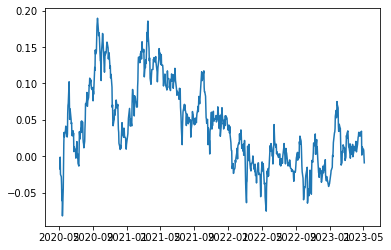

In [29]:
spread = np.log(price2) - beta * np.log(price1) - alpha
plt.plot(common_dates, spread)

## Prepare training / test data

In [30]:
scaler = MinMaxScaler(feature_range=(0,1))

def normalize_spread(data, scaler):
    scaled_data = scaler.fit_transform(data.reshape(-1,1))
    return scaled_data


def train_test_split(dates, data, test_ratio=0.2, window_size=30):
    assert len(dates) == len(data)
    test_size = int(len(dates) * test_ratio)
    train_size = len(dates) - test_size
    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(window_size, train_size):
        X_train.append(data[i - window_size:i])
        y_train.append(data[i])
    for i in range(train_size, train_size + test_size):
        X_test.append(data[i - window_size:i])
        y_test.append(data[i])
    print(f"Finishing splitting, training size: {len(X_train)}, testing size: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test, dates[:train_size], dates[train_size:]

def to_dataloader(X_train, y_train, X_test, y_test, batch_size):
    train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

scaled_spread = normalize_spread(spread, scaler)
X_train, y_train, X_test, y_test, train_dates, test_dates = train_test_split(common_dates, scaled_spread)
train_loader, test_loader = to_dataloader(X_train, y_train, X_test, y_test, batch_size=8)

Finishing splitting, training size: 574, testing size: 151


## LSTM Model

In [31]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the training function
def train(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 40 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Train the model
input_dim = 1
hidden_dim = 10
output_dim = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
train(model, train_loader, num_epochs, learning_rate)

Epoch [1/100], Step [40/72], Loss: 0.0013
Epoch [2/100], Step [40/72], Loss: 0.0030
Epoch [3/100], Step [40/72], Loss: 0.0020
Epoch [4/100], Step [40/72], Loss: 0.0009
Epoch [5/100], Step [40/72], Loss: 0.0022
Epoch [6/100], Step [40/72], Loss: 0.0006
Epoch [7/100], Step [40/72], Loss: 0.0006
Epoch [8/100], Step [40/72], Loss: 0.0008
Epoch [9/100], Step [40/72], Loss: 0.0012
Epoch [10/100], Step [40/72], Loss: 0.0015
Epoch [11/100], Step [40/72], Loss: 0.0017
Epoch [12/100], Step [40/72], Loss: 0.0019
Epoch [13/100], Step [40/72], Loss: 0.0021
Epoch [14/100], Step [40/72], Loss: 0.0022
Epoch [15/100], Step [40/72], Loss: 0.0023
Epoch [16/100], Step [40/72], Loss: 0.0024
Epoch [17/100], Step [40/72], Loss: 0.0024
Epoch [18/100], Step [40/72], Loss: 0.0024
Epoch [19/100], Step [40/72], Loss: 0.0025
Epoch [20/100], Step [40/72], Loss: 0.0025
Epoch [21/100], Step [40/72], Loss: 0.0025
Epoch [22/100], Step [40/72], Loss: 0.0025
Epoch [23/100], Step [40/72], Loss: 0.0025
Epoch [24/100], Step

Total MSE loss: 0.00013201477122493088


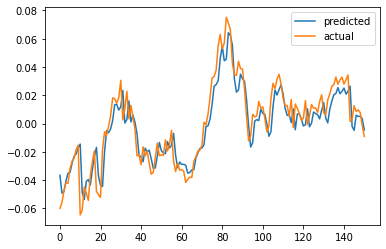

In [32]:
def test(model, test_loader):
    predictions = []
    batch_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            batch_labels.append(labels.numpy())
    return predictions, batch_labels

predictions, labels = test(model, test_loader)
predictions = scaler.inverse_transform(np.concatenate(predictions)).flatten()
labels = scaler.inverse_transform(np.concatenate(labels)).flatten()
# # # Visualize the results

plt.plot(predictions, label='predicted')
plt.plot(labels, label='actual')
print(f'Total MSE loss: {mean_squared_error(predictions, labels)}')
plt.legend()
plt.show()

## Trading Model

Suppose stock A and B are in the trade, and we modeled $$\log S_B = \beta \log S_A + \alpha$$
- Long A position: holding $1$ unit of stock A and $\beta$ unit of stock B; 
- Short A position: holding $-1$ unit of stock A and $\beta$ unit of stock B. 

Model 1 (Standard model): 
- Where $\mu$ and $\sigma$ are the statistics on the training data.
- Enter short A position when spread is over $\mu + 2\sigma$
- Enter long A position when spread is over $\mu - 2\sigma$
- Entering the position based the open price of the market

In [33]:
def simulate_standard_model(spread_pred, beta, mu, sigma, price_open_a, price_open_b, price_close_final_a, price_close_final_b):
    # Setup at t = 0
    # New idea by wenqi: if not hitting the bar, we just do nothing
    
#     if spread_pred[0] < mu: # logprice2 - beta * logprice1 < alpha, so long B
#         invest_a, invest_b = -1, beta
#         print(f'Initially long B, investing {beta}')
#     else:
#         invest_a, invest_b = 1, -beta
#         print(f'Initially long A, investing {1}')
        
    hold_a, hold_b = 0, 0
    invest_a, invest_b = None, None
    invest = 0
    histories = []

    num_test = len(y_test)
    for t in range(num_test):
        if spread_pred[t] < mu - 1 * sigma and (invest_a in [1, None]): # switch from long A to long B
            invest_adjust = (-1 - price_open_a[t] * hold_a) + (beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = -1, beta
            histories.append((t, invest_adjust, 'B'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long B, short A at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
            
        elif spread_pred[t] > mu + 1 * sigma and (invest_a in [-1, None]): # switch from long B to long A
            invest_adjust = (1 - price_open_a[t] * hold_a) + (-beta - price_open_b[t] * hold_b)
            invest += invest_adjust
            invest_a, invest_b = 1, -beta
            histories.append((t, invest_adjust, 'A'))
            hold_a, hold_b = invest_a / price_open_a[t], invest_b / price_open_b[t]
            print(f'Enter long A, short B at t={t}, invest_adjustment: {invest_adjust}')
            print(f'Hold A: {hold_a}, hold B: {hold_b}\n')
            
    
    # clear all investment
    invest_adjust = hold_a * price_close_final_a + hold_b * price_close_final_b    
    invest -= invest_adjust
    print(f'Final hold before clearing: {hold_a, hold_b}')
    print(f'Final investment to clear: {invest_adjust}')
    return invest, histories
        

mu, sigma = np.mean(labels), np.std(labels)
num_train, num_test = len(y_train), len(y_test)
price_open_a, price_open_b = np.array(stock1_common['Open'])[num_train:], np.array(stock2_common['Open'])[num_train:]
invest, histories = simulate_standard_model(predictions, beta, mu, sigma, price_open_a, price_open_b, price1[-1], price2[-1])
print('-' * 20)
print(f'Beta: {beta}')
print(f'Final investment: {invest}')
print(histories)

Enter long B, short A at t=0, invest_adjustment: 0.20442427731457058
Hold A: -0.005562354025976098, hold B: 0.004544311192588992

Enter long A, short B at t=78, invest_adjustment: -0.41748545171460183
Hold A: 0.005442176870748299, hold B: -0.0044312889308589145

Final hold before clearing: (0.005442176870748299, -0.0044312889308589145)
Final investment to clear: -0.2555310672217468
--------------------
Beta: 1.2044242773145706
Final investment: 0.04246989282171554
[(0, 0.20442427731457058, 'B'), (78, -0.41748545171460183, 'A')]


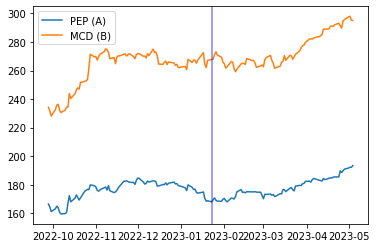

In [34]:
plt.figure()
plt.plot(test_dates, price1[num_train+30:], label='PEP (A)')
plt.plot(test_dates, price2[num_train+30:], label='MCD (B)')
plt.axvline(x=test_dates[79], color='b', alpha=0.5)
plt.legend()
plt.show()

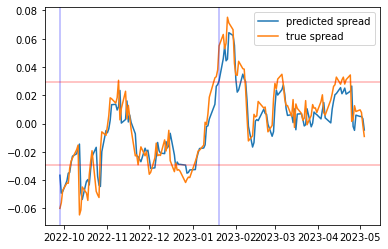

In [38]:
plt.figure()
plt.plot(test_dates, predictions, label='predicted spread')
plt.plot(test_dates, labels, label='true spread')
for t, invest_adj, long in histories:
    plt.axvline(x=test_dates[t], color='b', alpha=0.3)
plt.axhline(y=mu+sigma, color='r', alpha=0.3)
plt.axhline(y=mu-sigma, color='r', alpha=0.3)
plt.legend()
plt.show()